# Multiple databses processing processing

In [11]:
from netCDF4 import Dataset
import os
from os import walk
from os.path import join

from geopy import distance
import numpy as np
import pandas as pd

from datetime import datetime

In [12]:
PATH_DATABASES = "../afsV3"

# For the moment we are going to use one day
DAY_DATABASE = list(os.walk(PATH_DATABASES))[1][0]  
DATASABES_NAME = list(os.walk(PATH_DATABASES))[1][2]

DAY_DATABASE_OUTPUT = '../afsV3_csv/2020-12'

In [27]:
for db_name in DATASABES_NAME:
    file_path = os.path.join(DAY_DATABASE, db_name)
    ds = Dataset(file_path)
    
    type_boat = ds.variables['type'][:]
    lon = ds.variables['lon'][:]
    lat = ds.variables['lat'][:]
    
    distance_array = []
    non_masked_values_lat_lon = []
    # It takes a lot of processing power
    for id_boat in range(len(lat.data)):
        lat_lon = list(zip(np.array(lat[id_boat].data[~lat[id_boat].mask]), np.array(lon[id_boat].data[~lon[id_boat].mask])))
        lat_lon_cp = lat_lon.copy()

        lat_lon.pop()
        lat_lon_cp.pop(0)

        total_distance = sum(list(map(lambda x, y: distance.distance(x, y).km, lat_lon, lat_lon_cp)))
        distance_array.append(total_distance)
        non_masked_values_lat_lon.append(len(lat_lon))
        
    # Boats that traveled more than 50000 km
    index_superior_distance = np.where(np.array(distance_array) > 50000)

    # Boats that traveled less than 10 km
    index_inferior_distance = np.where(np.array(distance_array) < 10)

    # Boats that have more than 5000 observations
    index_masked_values = np.where(np.array(non_masked_values_lat_lon) > 5000)

    # Boats that don't have a class
    index_no_class = np.where(np.array(type_boat.data == 0))

    index_to_remove = np.unique(np.concatenate((index_superior_distance[0], 
                                                index_inferior_distance[0], 
                                                index_masked_values[0],
                                                index_no_class[0]
                                               ), axis=None))
        
    type_boat = np.delete(ds.variables['type'][:], index_to_remove) # Doesn't have fill value
    mmsi = np.delete(ds.variables['mmsi'][:], index_to_remove) # Doesn't have fill value
    time = np.delete(ds.variables['time'][:], index_to_remove, 0) # Fill value -2147483600.0
    lon = np.delete(ds.variables['lon'][:], index_to_remove, 0) # Fill value -999.0
    lat = np.delete(ds.variables['lat'][:], index_to_remove, 0) # Fill value -99.0
    cog = np.delete(ds.variables['cog'][:], index_to_remove, 0) # Fill value 1023.0,
    sog = np.delete(ds.variables['sog'][:], index_to_remove, 0) # Fill value 3600.0
    trh = np.delete(ds.variables['trh'][:], index_to_remove, 0) # Fill value 511.0
    
    df_complete = pd.DataFrame(columns=['mmsi', 'lat', 'lon', 'cog', 'sog', 'trh', 'time', 
                           'formatted_time', 'formatted_date', 'seq_number', 'observation_id'])

    for id_boat in range(len(lat.data)):
        lat_aux = lat[id_boat].data[~(lat[id_boat].data == lat.fill_value)]
        lon_aux = lon[id_boat].data[~(lon[id_boat].data == lon.fill_value)]
        cog_aux = cog[id_boat].data[~(cog[id_boat].data == cog.fill_value)]
        sog_aux = sog[id_boat].data[~(sog[id_boat].data == sog.fill_value)]
        trh_aux = trh[id_boat].data[~(trh[id_boat].data == trh.fill_value)]
        time_aux = time[id_boat].data[~(time[id_boat].data == time.fill_value)]

        if (len(lat_aux) == len(lon_aux) == len(cog_aux) == len(sog_aux) == len(trh_aux) == len(time_aux)):
            data = {'mmsi': str(int(mmsi[id_boat])),
                'boat_type': str(int(type_boat[id_boat])),
                'lat': lat_aux,
                'lon': lon_aux,
                'cog': cog_aux,
                'sog': sog_aux,
                'trh': trh_aux,
                'time': time_aux} 

            df = pd.DataFrame(data) 
            df['formatted_time'] = df.time.apply(lambda x: datetime.fromtimestamp(int(x)).time().isoformat())
            df['formatted_date'] = df.time.apply(lambda x: datetime.fromtimestamp(int(x)).date().isoformat())
            df['observation_id'] = id_boat

            ## Should we order by date?
            df_index = df.index.copy()
            df.sort_values('time', ascending=True, inplace=True)

            df['time_diff'] = df.time.diff()
            df['seq_number'] = df_index

            df_complete = df_complete.append(df, ignore_index=True)
            
    df_complete.to_csv(os.path.join(DAY_DATABASE_OUTPUT, db_name.replace(".nc", '.csv')), index = False)

In [52]:
li = []
for db_name in DATASABES_NAME:
    df = pd.read_csv(os.path.join(DAY_DATABASE_OUTPUT, db_name.replace(".nc", '.csv')))
    li.append(df)

In [53]:
for index, value in enumerate(li):
    if index > 0:
        last_val = li[index-1].observation_id.max()
        li[index]['observation_id'] = li[index]['observation_id'] + last_val + 1

In [54]:
df_complete = pd.concat(li, axis=0, ignore_index=True)

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
df_complete.boat_type.value_counts()

70    4906675
30     333552
31      25347
33      21378
52      19547
20       9375
10       5129
32       4637
59       4144
50       2761
60       2432
38        442
57         85
Name: boat_type, dtype: int64

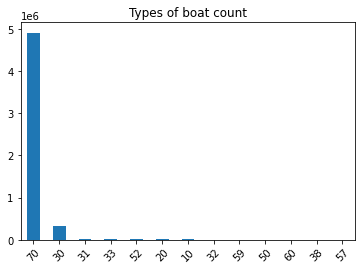

In [57]:
df_complete.boat_type.value_counts().plot(kind = 'bar')
plt.xticks(rotation = 45)
plt.title('Types of boat count')
plt.show()

In [ ]:
# For the moment class 70 and 30

In [58]:
df_3070 = df_complete[(df_complete.boat_type == 70) | (df_complete.boat_type == 30)].copy()
df_3070.dropna(inplace=True)
df_3070.head()

,mmsi,lat,lon,cog,sog,trh,time,formatted_time,formatted_date,seq_number,observation_id,boat_type,time_diff
1,256448000,-33.005613,27.973855,2.200000,0.3,210.0,1.606782e+09,01:12:45,2020-12-01,1,0,70,542.0
2,256448000,-33.005603,27.973860,33.799999,0.0,214.0,1.606782e+09,01:15:45,2020-12-01,2,0,70,180.0
3,256448000,-33.005617,27.973818,234.899994,0.3,212.0,1.606782e+09,01:18:44,2020-12-01,3,0,70,179.0
4,256448000,-33.005655,27.973780,215.300003,0.2,211.0,1.606782e+09,01:21:40,2020-12-01,4,0,70,176.0
5,256448000,-33.005655,27.973780,215.300003,0.2,211.0,1.606782e+09,01:21:41,2020-12-01,5,0,70,1.0


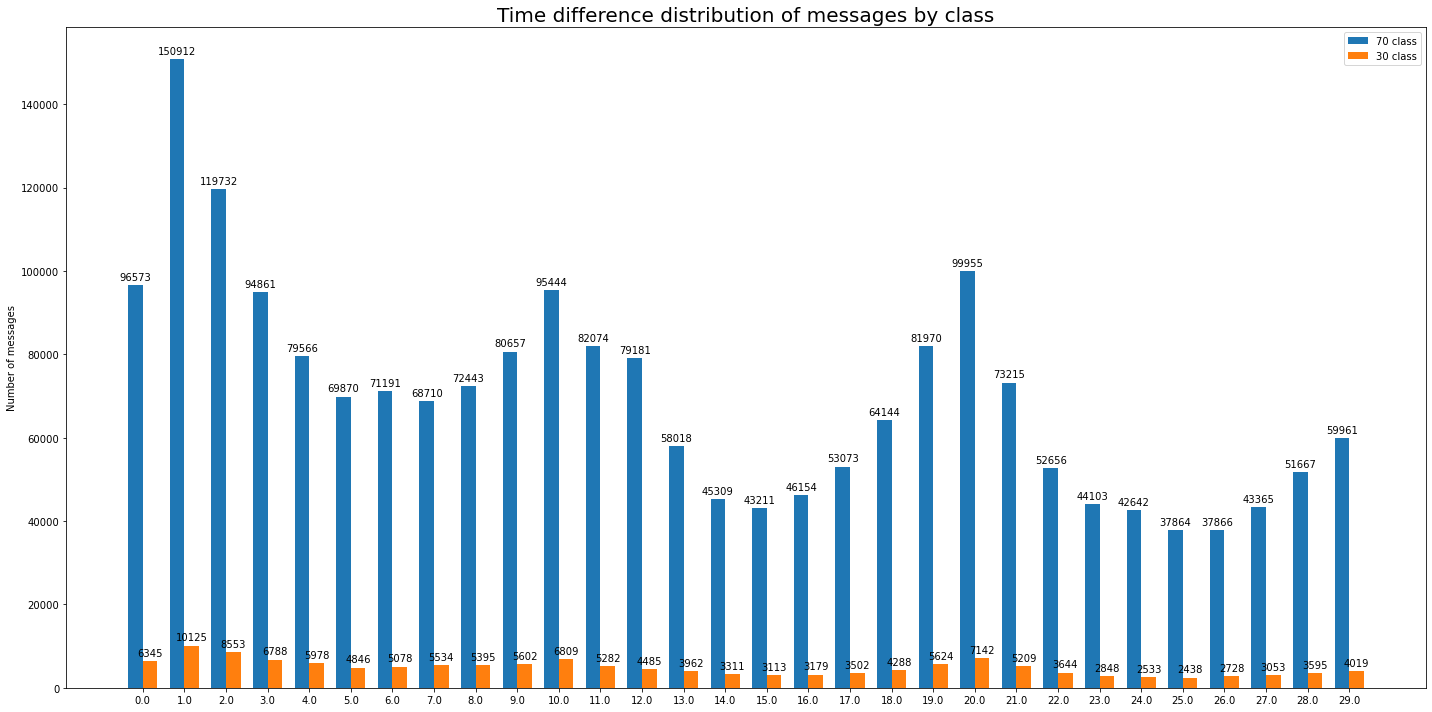

In [59]:
labels = df_3070[(df_3070.time_diff < 30)].time_diff.value_counts().sort_index().index
#class_total = df_3070[(df_3070.time_diff < 30)].time_diff.value_counts().sort_index()
class_70 = df_3070[(df_3070.time_diff < 30) & (df_3070.boat_type == 70)].time_diff.value_counts().sort_index()
class_30 = df_3070[(df_3070.time_diff < 30) & (df_3070.boat_type == 30)].time_diff.value_counts().sort_index()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/2, class_70, width, label='70 class')
rects2 = ax.bar(x + width/2, class_30, width, label='30 class')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of messages')
ax.set_title('Time difference distribution of messages by class', fontsize = 20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [72]:
df_3070 = df_3070[df_3070.time_diff != 0]

In [73]:
df_3070.shape

(5132430, 14)

In [87]:
len(obs_ids)

5132430

In [78]:
obs_ids = np.array(df_3070.observation_id.values)
time_diff = np.array(df_3070.time_diff.values)
new_obs_ids = obs_ids.copy()

In [100]:
def get_segments_index(obs_ids, time_diff, new_obs_ids,
                      wrong_value = -99, min_interval = 8,
                       max_interval = 13, seq_size = 10):
    i = 0

    counter = 0
    new_id = 0

    while i < len(obs_ids):
        if counter == seq_size:
            counter = 0
            new_id += 1
            
        if time_diff[i] > max_interval:
            counter = 0
            new_id += 1
            new_obs_ids[i] = wrong_value
            
        elif ((time_diff[i] <= max_interval) & (time_diff[i] >= min_interval)):
            new_obs_ids[i] = new_id
            
            if (new_obs_ids[i-1] == wrong_value):
                new_obs_ids[i-1] = new_id
                counter += 1
            counter += 1
             
        else:   
            counter = 0
            new_id += 1    
            new_obs_ids[i] = wrong_value  
        i += 1   
    return(new_obs_ids)

In [84]:
from tqdm import tqdm

In [85]:
n_segments_30 = []
n_segments_70 = []
min_segment = 2
max_segment = 10

for j in tqdm(range(min_segment, max_segment)):
    res = get_segments_index(obs_ids, time_diff, new_obs_ids, seq_size = j)
    df_3070['new_observation_id'] = res
    df_seq = df_3070.groupby('new_observation_id').filter(lambda x: len(x) == j)
    aux = df_seq.boat_type.value_counts()
    if (len(aux) == 2):
        n_segments_30.append(aux.values[1]/j)
        n_segments_70.append(aux.values[0]/j)
    elif (len(aux) == 1):
        n_segments_30.append(0)
        n_segments_70.append(aux.values[0]/j)
    else:
        n_segments_30.append(0)
        n_segments_70.append(0)  

100%|█████████████████████████████████████████████| 8/8 [01:11<00:00,  8.94s/it]


In [98]:
df_seq[df_seq.boat_type == 70].groupby('new_observation_id').filter(lambda x: len(x) != 4)

,mmsi,lat,lon,cog,sog,trh,time,formatted_time,formatted_date,seq_number,observation_id,boat_type,time_diff,new_observation_id
1745735,477276200,-33.585145,30.802453,68.900002,10.7,66.0,1.607990e+09,00:58:50,2020-12-15,1839,1900,70,77.0,1524668


In [99]:
df_seq[df_seq.boat_type == 30].groupby('new_observation_id').filter(lambda x: len(x) != 4)

,mmsi,lat,lon,cog,sog,trh,time,formatted_time,formatted_date,seq_number,observation_id,boat_type,time_diff,new_observation_id
1745737,412420653,-33.222337,30.997717,249.899994,13.2,254.0,1.607975e+09,20:49:44,2020-12-14,1,1901,30,11.0,1524668
1745738,412420653,-33.222553,30.997013,250.100006,13.4,255.0,1.607975e+09,20:49:53,2020-12-14,2,1901,30,9.0,1524668
1745739,412420653,-33.222713,30.996457,252.899994,13.3,255.0,1.607975e+09,20:50:04,2020-12-14,3,1901,30,11.0,1524668


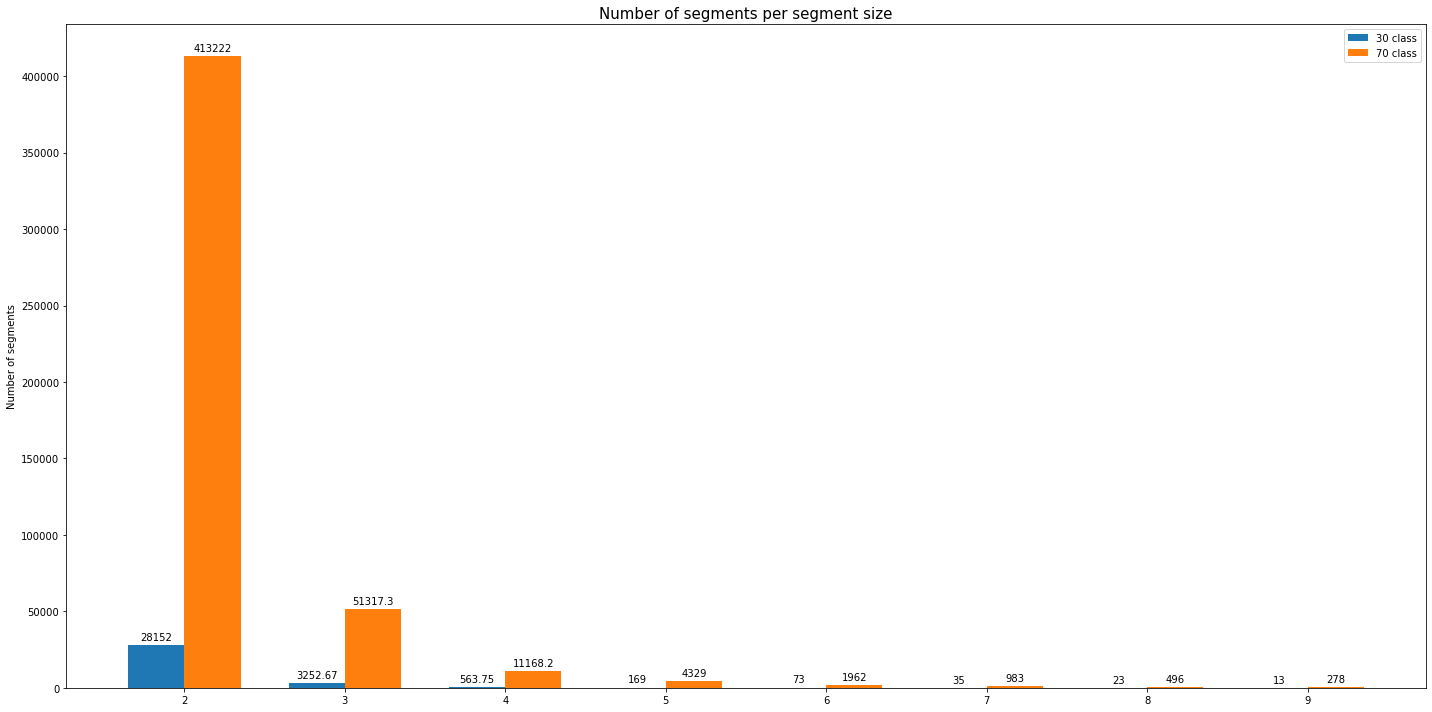

In [88]:
labels = range(min_segment, max_segment)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/2, n_segments_30, width, label='30 class')
rects2 = ax.bar(x + width/2, n_segments_70, width, label='70 class')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of segments')
ax.set_title('Number of segments per segment size', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

In [102]:
import tensorflow as tf
tf.config.experimental.list_physical_devices(device_type=None)

2021-11-11 23:04:21.190220: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-11 23:04:21.190276: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ideapad): /proc/driver/nvidia/version does not exist


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [103]:
import random

In [101]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix

2021-11-11 23:04:06.840563: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-11 23:04:06.840587: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [104]:
pl.seed_everything(42)

Global seed set to 42


42

In [107]:
res = get_segments_index(obs_ids, time_diff, new_obs_ids, seq_size = 4)
df_3070['new_observation_id'] = res
df_ = df_3070.groupby('new_observation_id').filter(lambda x: len(x) == 4).copy()

In [106]:
# Hotfix of get_Segments_index
hf_70 = df_[df_.boat_type == 70].groupby('new_observation_id').filter(lambda x: len(x) == 4)
hf_30 = df_[df_.boat_type == 30].groupby('new_observation_id').filter(lambda x: len(x) == 4)

In [108]:
df_8 = pd.concat([hf_70, hf_30], axis=0, ignore_index=True)

In [112]:
sample_id_30 = df_8[df_8.boat_type == 30].new_observation_id.unique()
sample_id_70 = random.sample(sorted(df_8[df_8.boat_type == 70].new_observation_id.unique()), 563*2)

In [113]:
balanced_sample = df_8[(df_8.new_observation_id.isin(sample_id_30)) | (df_8.new_observation_id.isin(sample_id_70))].copy()

In [114]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(balanced_sample.boat_type) 

In [116]:
balanced_sample["label"] = encoded_labels

FEATURE_COLUMNS = ['lat', 'lon', 'cog', 'sog', 'trh']
FEATURE_COLUMNS

['lat', 'lon', 'cog', 'sog', 'trh']

In [117]:
sequences = []

for series_id, group in balanced_sample.groupby("new_observation_id"):
    sequence_features = group[FEATURE_COLUMNS]
    label = balanced_sample[balanced_sample.new_observation_id == series_id].iloc[0].label
    
    sequences.append((sequence_features, label))

In [118]:
train_sequences, test_sequences = train_test_split(sequences, test_size = 0.2)

In [119]:
class BoatDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(
            sequence=torch.Tensor(sequence.to_numpy()),
            label=torch.tensor(label).long()
        )

In [120]:
class BoatDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        
    def setup(self, stage=None):
        self.train_dataset = BoatDataset(self.train_sequences)
        self.test_dataset = BoatDataset(self.test_sequences)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=cpu_count()
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )
    

In [121]:
N_EPOCHS = 300
BATCH_SIZE = 1000

data_module = BoatDataModule(train_sequences, test_sequences, BATCH_SIZE)

In [122]:
class SequenceModel(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.75
        )
        
        self.classifier = nn.Linear(n_hidden, n_classes)
        
    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        
        out = hidden[-1]
        
        return self.classifier(out)

In [123]:
class BoatPredictor(pl.LightningModule):
    def __init__(self, n_features: int, n_classes: int):
        super().__init__()
        self.model = SequenceModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim = 1)
        step_accuracy = accuracy(predictions, labels)

        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {'loss': loss, 'accuracy': step_accuracy}
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim = 1)
        step_accuracy = accuracy(predictions, labels)

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {'loss': loss, 'accuracy': step_accuracy}
    
    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim = 1)
        step_accuracy = accuracy(predictions, labels)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {'loss': loss, 'accuracy': step_accuracy}
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)

In [124]:
model = BoatPredictor(
    n_features=len(FEATURE_COLUMNS), 
    n_classes=2)

In [125]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

In [126]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="var_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="surface")

trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    max_epochs=N_EPOCHS,
    progress_bar_refresh_rate=0
)

/home/emilio/anaconda3/envs/fml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f01b4e4efd0>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f01b4e4efd0>)`.
  rank_zero_deprecation(
/home/emilio/anaconda3/envs/fml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(


In [127]:
trainer.fit(model, data_module)


  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SequenceModel    | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.290     Total estimated model params size (MB)
Global seed set to 42
/home/emilio/anaconda3/envs/fml/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:393: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


In [130]:
trainer.test(dataloaders=data_module)

/home/emilio/anaconda3/envs/fml/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1391: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.model_checkpoint.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at lightning_logs/surface/version_0/checkpoints/epoch=299-step=599.ckpt
Loaded model weights from checkpoint at lightning_logs/surface/version_0/checkpoints/epoch=299-step=599.ckpt


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9142012000083923, 'test_loss': 0.2168135792016983}
--------------------------------------------------------------------------------


[{'test_loss': 0.2168135792016983, 'test_accuracy': 0.9142012000083923}]

In [128]:
model.freeze()

test_dataset = BoatDataset(test_sequences)

predictions = []
labels = []

for item in tqdm(test_dataset):
    sequence = item["sequence"]
    label = item["label"]
    
    _, output = model(sequence.unsqueeze(dim = 0))
    predictions.append(torch.argmax(output, dim = 1).numpy()[0])
    labels.append(label.item())

100%|████████████████████████████████████████| 338/338 [00:00<00:00, 841.96it/s]


In [129]:
test_results = pd.DataFrame.from_dict({'predictions': predictions, 'labels': labels})
test_results.head(10)

,predictions,labels
0,1,1
1,1,1
2,1,1
3,0,0
4,0,0
5,1,1
6,1,0
7,0,0
8,1,1
9,1,1


In [131]:
test_results.shape[0]

338

In [132]:
test_results[test_results.predictions == test_results.labels].shape[0]

309

In [133]:
test_results[test_results.predictions != test_results.labels].shape[0]

29

In [134]:
errors_ = test_results[test_results.predictions != test_results.labels]
errors_

,predictions,labels
6,1,0
16,1,0
18,1,0
37,0,1
43,0,1
54,0,1
59,1,0
72,0,1
77,0,1
108,1,0


In [135]:
# Class 70
(errors_.labels == 1).sum()

19

In [136]:
# Class 30
(errors_.labels == 0).sum()

10